### Import libraries


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft # For the fourier transform
from scipy.interpolate import griddata # For the interpolation
from scipy.optimize import curve_fit

### Import point clouds

Assuming slip to be in the $\pm x$ direction, fault normal to be in the $\pm z$ direction.  

In [ ]:
# Import the data (Only x, y, z coordinates)
data = np.loadtxt('../surfaces/vertices.txt', usecols=(0,1,2))

### Define functions

- `interpolate` takes in a DEM in .txt form and fits the data to a regular grid
- `psd` computes the average power series density (PSD) of each row ($\pm x$ direction) of the input grid
- `plot_psd_log` plots the PSD against the corresponding wavenumbers in log-log space and computes the Hurst exponent

In [88]:
def interpolate(raw_data):
    """
    Interpolates the data onto a regular grid.

    Input:
    raw_data: The raw data to be interpolated. 
    Should be a numpy array with 3 columns, where the first two columns are the x and y coordinates, 
    and the third column is the z coordinate.

    Output:
    fit_data: Data interpolated onto a regular grid.
    """

    # Spacing of the grid
    # Calculated by taking the difference between the first two points
    x_spacing = abs(round(raw_data[0,0] - raw_data[1,0], 3)) # Round to 2 decimal places
    y_spacing = abs(round(raw_data[0,1] - raw_data[1,1], 3))

    # Length of the grid in x and y
    # Calculated by taking the difference between the first and last points
    x_length = abs(round(raw_data[0,0] - raw_data[-1,0], 3))
    y_length = abs(round(raw_data[0,1] - raw_data[-1,1], 3))
    
    # Create a regular grid using meshgrid
    # Here, length // spacing = number of points
    x = np.linspace(np.min(raw_data[:,0]), np.max(raw_data[:,0]), int(x_length // x_spacing)) 
    y = np.linspace(np.min(raw_data[:,1]), np.max(raw_data[:,1]), int(y_length // y_spacing))
    X, Y = np.meshgrid(x, y)

    # Interpolate the data onto the grid
    # fit_data[0] is the bottom row, fit_data[-1] is the top row. fit_data[:,0] is the left column, fit_data[:,-1] is the right column. 
    # Index row by row by going from fit_data[0] to fit_data[-1] for fft.
    fit_data = griddata(raw_data[:,0:2], raw_data[:,2], (X, Y), method='linear')

    # Remove any NaN values by replacing them with the mean of the data
    fit_data = np.nan_to_num(fit_data, nan=np.nanmean(fit_data))

    # Plot the data
    plt.contourf(X, Y, fit_data, 100, cmap='jet')
    plt.colorbar()
    plt.show()

    return fit_data

def psd(data_array):
    """
    Performs an FFT row by row on the input array. Each FFT output is then converted to PSD as a function of wavenumber (1 / frequency).
    
    """
    # Perform the FFT on each row
    fft_data = np.fft.fft(data_array, axis=1)
    
    # Calculate the PSD from the FFT data (only the real part is needed)
    psd_data = np.abs(fft_data)**2

    # Take the mean psd of all the rows
    psd_data = np.mean(psd_data, axis=0)
    
    # Calculate the wavenumber (reciprocal of frequency)
    # The wavenumber is the same for each row, so we can just calculate it once
    wavenumber = np.fft.fftfreq(len(data_array[0]))

    # Remove the negative (and 0) wavenumbers and corresponding psd data
    # This is because 1) the PSD is symmetry about 0 and 
    # 2) We have to take the log of each value later
    psd_data = psd_data[wavenumber > 0]
    wavenumber = wavenumber[wavenumber > 0]
    
    return wavenumber, psd_data

def plot_psd_log(wavenumber, psd_data):
    """
    Plots the PSD data as a function of wavenumber on a log-log scale.

    Input:
    wavenumber: The wavenumber data.
    psd_data: The PSD data.
    """
    # Fit a line to the log of the data
    def func(x, a, b): return a*x + b # Linear function
    popt, pcov = curve_fit(func, np.log(wavenumber), np.log(psd_data)) # Fit

    # Print the Hurst exponent (slope + 1) / -2
    print('Hurst exponent:', (popt[0] + 1) / -2)

    plt.scatter(wavenumber, psd_data)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Wavenumber')
    plt.ylabel('PSD')
    plt.title('PSD as a function of wavenumber')
    plt.show()


### Execute (Will be streamlined later)

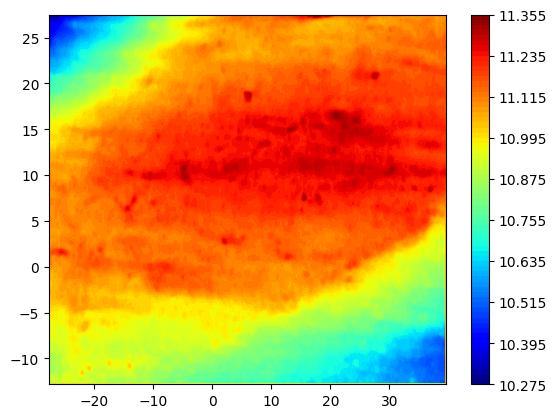

In [77]:
gridded_data = interpolate(data) # Interpolate the data onto a regular grid

Hurst exponent: 0.41594188432511636


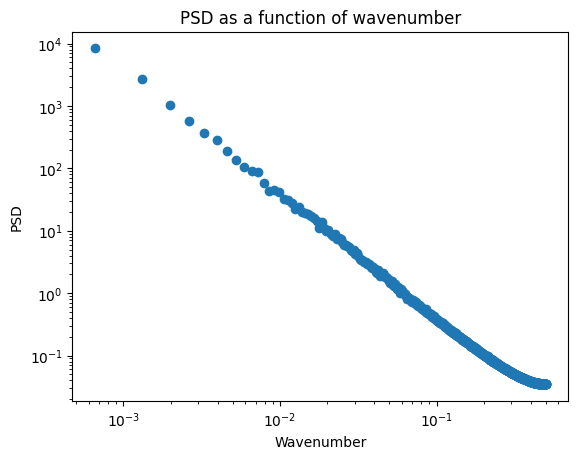

In [89]:
wavenumber, psd_data = psd(gridded_data) # Calculate the PSD data
plot_psd_log(wavenumber, psd_data) # Plot the PSD data